In [7]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from utils import *
from dataset import create_file_path_dict
import mne
from sklearn.preprocessing import StandardScaler

In [8]:
MEG_SUBJECT = "A"
FMRI_SUBJECT = f"UTavg-to-Moth_{MEG_SUBJECT}"
SAVEFIG = False

DATASET_DIR = "/data/story_dataset"  # change to your dataset path
FMRI_DIR = "src_fmri"
spacing = "oct6"

In [9]:
TRAIN_SESSIONS = ["Moth1", "Moth2", "Moth3", "Moth4", "Moth5"]
TEST_SESSIONS = ["Moth2", "Moth3", "Moth4", "Moth5"]
train_story_list = dict(
    Moth1=["souls", "avatar", "legacy", "odetostepfather"],
    Moth2=["howtodraw", "myfirstdaywiththeyankees", "naked", "life"],
    Moth3=["tildeath", "fromboyhoodtofatherhood", "sloth", "exorcism"],
    Moth4=["adollshouse", "inamoment", "theclosetthatateeverything", "adventuresinsayingyes", "haveyoumethimyet"],
    Moth5=["thatthingonmyarm", "eyespy", "itsabox", "hangtime"],
)
train_stories = [story for session in TRAIN_SESSIONS for story in train_story_list[session]]
test_story_list = dict(
    Moth1=["alternateithicatom1", "alternateithicatom2"],
    Moth2=["undertheinfluence1", "undertheinfluence2"],
    Moth3=["stagefright1", "stagefright2"],
    Moth4=["buck1", "buck2"],
    Moth5=["swimmingwithastronauts1", "swimmingwithastronauts2"],
)
test_stories = [story for session in TEST_SESSIONS for story in test_story_list[session] if story.endswith("1")]  # we only need one

In [10]:
# we need path of design matrix
file_path_dict = create_file_path_dict(MEG_SUBJECT, FMRI_SUBJECT, train_stories, DATASET_DIR=DATASET_DIR)

In [11]:
# story to unique story mapping
with open("data/story_to_uniquestory.pkl", "rb") as f:
    story_to_uniquestory = pickle.load(f)
print(story_to_uniquestory)

{'stimuli_auditory_localizer': 'stimuli_auditory_localizer', 'alternateithicatom1': 'alternateithicatom', 'souls': 'souls', 'wheretheressmoke1': 'wheretheressmoke', 'avatar': 'avatar', 'legacy': 'legacy', 'odetostepfather': 'odetostepfather', 'alternateithicatom2': 'alternateithicatom', 'undertheinfluence1': 'undertheinfluence', 'howtodraw': 'howtodraw', 'myfirstdaywiththeyankees': 'myfirstdaywiththeyankees', 'wheretheressmoke2': 'wheretheressmoke', 'naked': 'naked', 'life': 'life', 'undertheinfluence2': 'undertheinfluence', 'stagefright1': 'stagefright', 'tildeath': 'tildeath', 'wheretheressmoke3': 'wheretheressmoke', 'fromboyhoodtofatherhood': 'fromboyhoodtofatherhood', 'sloth': 'sloth', 'exorcism': 'exorcism', 'stagefright2': 'stagefright', 'buck1': 'buck', 'adollshouse': 'adollshouse', 'wheretheressmoke4': 'wheretheressmoke', 'inamoment': 'inamoment', 'theclosetthatateeverything': 'theclosetthatateeverything', 'adventuresinsayingyes': 'adventuresinsayingyes', 'haveyoumethimyet': 'h

In [12]:
all_stories = train_stories + test_stories
all_stories

['souls',
 'avatar',
 'legacy',
 'odetostepfather',
 'howtodraw',
 'myfirstdaywiththeyankees',
 'naked',
 'life',
 'tildeath',
 'fromboyhoodtofatherhood',
 'sloth',
 'exorcism',
 'adollshouse',
 'inamoment',
 'theclosetthatateeverything',
 'adventuresinsayingyes',
 'haveyoumethimyet',
 'thatthingonmyarm',
 'eyespy',
 'itsabox',
 'hangtime',
 'undertheinfluence1',
 'stagefright1',
 'buck1',
 'swimmingwithastronauts1']

## Prepare fMRI Data

In [13]:
# load fMRI data, which is nTRs * nVoxels for each story
data_file_template = f"{DATASET_DIR}/{FMRI_DIR}/{spacing}/{FMRI_SUBJECT}_{{}}"
fmri_data_dict = dict()
for story in all_stories:
    this_story_unique = story_to_uniquestory[story]
    stc_fmri = mne.read_source_estimate(data_file_template.format(this_story_unique))
    tmp_data = stc_fmri.data.T
    if np.any(np.isnan(tmp_data)):
        print(f"story {story} has nan")
        tmp_data = np.nan_to_num(tmp_data)
    fmri_data_dict[story] = tmp_data
    print(f"story {story}: \t{fmri_data_dict[story].shape[0]} TRs\t {fmri_data_dict[story].shape[1]} voxels")

story souls: 	355 TRs	 8196 voxels
story avatar: 	367 TRs	 8196 voxels
story legacy: 	400 TRs	 8196 voxels
story odetostepfather: 	404 TRs	 8196 voxels
story howtodraw: 	354 TRs	 8196 voxels
story myfirstdaywiththeyankees: 	358 TRs	 8196 voxels
story naked: 	422 TRs	 8196 voxels
story life: 	430 TRs	 8196 voxels
story tildeath: 	323 TRs	 8196 voxels
story fromboyhoodtofatherhood: 	348 TRs	 8196 voxels
story sloth: 	437 TRs	 8196 voxels
story exorcism: 	467 TRs	 8196 voxels
story adollshouse: 	241 TRs	 8196 voxels
story inamoment: 	205 TRs	 8196 voxels
story theclosetthatateeverything: 	314 TRs	 8196 voxels
story adventuresinsayingyes: 	391 TRs	 8196 voxels
story haveyoumethimyet: 	496 TRs	 8196 voxels
story thatthingonmyarm: 	434 TRs	 8196 voxels
story eyespy: 	379 TRs	 8196 voxels
story itsabox: 	355 TRs	 8196 voxels
story hangtime: 	324 TRs	 8196 voxels
story undertheinfluence1: 	304 TRs	 8196 voxels
story stagefright1: 	293 TRs	 8196 voxels
story buck1: 	332 TRs	 8196 voxels
story s

## Prepare Embeddings

### Load Stimulus Embedding

In [14]:
embeds_dict = {}
for story in all_stories:
    mats = []
    with open(file_path_dict["word"], "rb") as f:
        mats.append(pickle.load(f)[story])
    with open(file_path_dict["phoneme"], "rb") as f:
        mats.append(pickle.load(f)[story])
    with open(file_path_dict["spectrum"], "rb") as f:
        mats.append(pickle.load(f)[story])

    # trim to shortest and concat
    min_len = min(m.shape[0] for m in mats)
    mats = [m[:min_len] for m in mats]
    embeds = np.concatenate(mats, axis=1)

    embeds_dict[story] = embeds

### Aligning to TR Timing

In [15]:
# get the embedding matrix step by TR
TR_length = 2
embed_TRs_dict = dict()

for story in all_stories:

    print(story)

    # create a nTRs * size_embedding matrix
    embeds_this_story = embeds_dict[story]
    nTRs = fmri_data_dict[story].shape[0]
    while nTRs * 100 + 500 > embeds_this_story.shape[0]:
        nTRs -= 1
        print(f"Cut off 1 TR, for story {story}")
    fmri_data_dict[story] = fmri_data_dict[story][:nTRs]

    TR_times = np.arange(1, nTRs + 1) * TR_length  # This is a bug in HW2
    size_embedding = embeds_this_story.shape[1]
    meg_embedding_TRs_this_story = np.zeros((nTRs, size_embedding))
    for itr, tr in enumerate(TR_times):
        meg_embedding_TRs_this_story[itr] = embeds_this_story[500 + itr * 100 : 500 + (itr + 1) * 100].mean(0)

    embed_TRs_dict[story] = meg_embedding_TRs_this_story

souls
avatar
legacy
odetostepfather
howtodraw
myfirstdaywiththeyankees
naked
life
tildeath
fromboyhoodtofatherhood
Cut off 1 TR, for story fromboyhoodtofatherhood
Cut off 1 TR, for story fromboyhoodtofatherhood
Cut off 1 TR, for story fromboyhoodtofatherhood
sloth
exorcism
adollshouse
inamoment
theclosetthatateeverything
adventuresinsayingyes
haveyoumethimyet
thatthingonmyarm
eyespy
itsabox
hangtime
undertheinfluence1
stagefright1
buck1
swimmingwithastronauts1


### Z-Score

In [16]:
# get the standard scaler from the training matrix
train_design_matrices = []
for story in train_stories:
    print(story)
    story_embed_TRs = embed_TRs_dict[story]
    train_design_matrices.append(story_embed_TRs)

# concatenate all training design matrices
train_design_matrix = np.concatenate(train_design_matrices, axis=0)
del train_design_matrices

# normalization
scaler = StandardScaler()
scaler.fit(train_design_matrix)
del train_design_matrix

souls
avatar
legacy
odetostepfather
howtodraw
myfirstdaywiththeyankees
naked
life
tildeath
fromboyhoodtofatherhood
sloth
exorcism
adollshouse
inamoment
theclosetthatateeverything
adventuresinsayingyes
haveyoumethimyet
thatthingonmyarm
eyespy
itsabox
hangtime


In [17]:
for story in all_stories:
    print(story)
    story_embed_TRs = embed_TRs_dict[story]
    story_embed_TRs = scaler.transform(story_embed_TRs)
    embed_TRs_dict[story] = story_embed_TRs

souls
avatar
legacy
odetostepfather
howtodraw
myfirstdaywiththeyankees
naked
life
tildeath
fromboyhoodtofatherhood
sloth
exorcism
adollshouse
inamoment
theclosetthatateeverything
adventuresinsayingyes
haveyoumethimyet
thatthingonmyarm
eyespy
itsabox
hangtime
undertheinfluence1
stagefright1
buck1
swimmingwithastronauts1


### Get Delayed Embeddings

In [18]:
# delay functions
def delay_one(mat, d):
    # delays a matrix by a delay d. Positive d ==> row t has row t-d
    new_mat = np.zeros_like(mat)
    if d > 0:
        new_mat[d:] = mat[:-d]
    elif d < 0:
        new_mat[:d] = mat[-d:]
    else:
        new_mat = mat
    return new_mat


def delay_mat(mat, delays):
    # delays a matrix by a set of delays d.
    # a row t in the returned matrix has the concatenated:
    # row(t-delays[0],t-delays[1]...t-delays[last] )
    new_mat = np.concatenate([delay_one(mat, d) for d in delays], axis=-1)
    return new_mat

In [19]:
delays = np.arange(1, 5)
embed_TRs_delayed_dict = dict([(story, delay_mat(mat, delays)) for story, mat in embed_TRs_dict.items()])

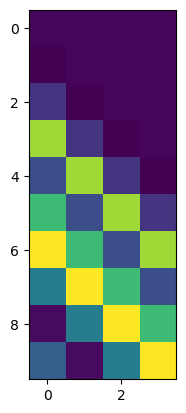

In [20]:
# example
s = embed_TRs_dict["souls"].shape[1]
plt.imshow(embed_TRs_delayed_dict["souls"][:10, [0, s, s * 2, s * 3]])

## Prepare Train and Test Data

(From Leila) Typically, we always zscore **each run** (i.e., in this case, each story) of data separately.

In [21]:
# get trainning meg embeddings and fmri data
train_embeds = np.concatenate([embed_TRs_delayed_dict[this_story] for this_story in train_stories], axis=0)
train_fmri_data = np.concatenate([nan_zscore(fmri_data_dict[this_story]) for this_story in train_stories], axis=0)
print("train meg embedding shape:", train_embeds.shape)
print("train fmri data shape:", train_fmri_data.shape)

train meg embedding shape: (7801, 3408)
train fmri data shape: (7801, 8196)


In [22]:
# get test meg embeddings and fmri data
test_embeds = np.concatenate([embed_TRs_delayed_dict[this_story] for this_story in test_stories], axis=0)
test_fmri_data = np.concatenate([nan_zscore(fmri_data_dict[this_story]) for this_story in test_stories], axis=0)
print("test meg embedding shape:", test_embeds.shape)
print("test fmri data shape:", test_fmri_data.shape)

test meg embedding shape: (1314, 3408)
test fmri data shape: (1314, 8196)


## Fit Ridge

In [23]:
from src.model_fitting_funcs import ridge_fit_predict_torch
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [24]:
# fit ridge regression
n_splits = 5
alphas = [10**j for j in range(-6, 10)]
corrs, r2s, weights = ridge_fit_predict_torch(train_embeds, train_fmri_data, test_embeds, test_fmri_data, n_splits=n_splits, alphas=alphas, return_coefs=True, device=device)

Time taken for one fold: 1.11 sec
Time taken for one fold: 0.56 sec
Time taken for one fold: 0.56 sec
Time taken for one fold: 0.56 sec
Time taken for one fold: 0.56 sec


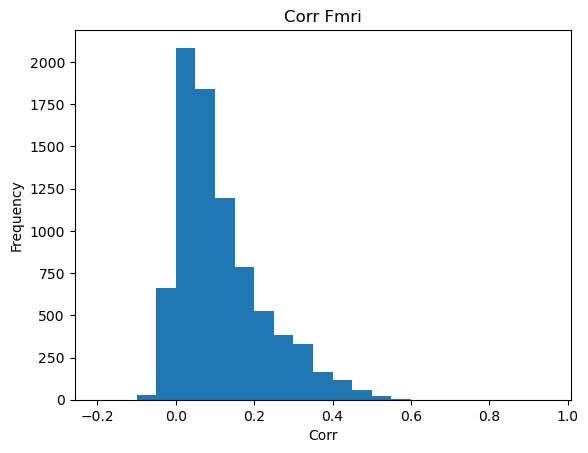

In [25]:
plt.hist(corrs, bins=np.arange(-0.2, 1, 0.05))
plt.title("Corr Fmri")
plt.xlabel("Corr")
plt.ylabel("Frequency")
plt.show()